In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload
import lmfit as lm


class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        ###Add temperature values here
        ### Add angle of the beam here => 
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

class XMCD_data_analysis(Nexus_handling):
    def __init__(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []
        #self.temperature
    
    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx
 
        for ﬁle_number in XMCD_spectra_Set: #
            print(ﬁle_number)
            data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
            self.energy = self.spectra[0]["x"]
#######################################################################################
    ### Plotting functions
    
    def plot_spectra(self,XAS_file_Set,i):
        #Plots a single XAS spectra out of a set 
        #XAS_file_set : a set of XAS scan numbers
        #i : the indice of which scan you want to plot
        Energy,Idio = XMCD.spectra[i]["x"],XMCD.spectra[i]["y"]
        plt.plot(Energy,Idio,label = XAS_file_Set[i])
        plt.title(("XAS ",sensor,XAS_file_set[i],self.spectra[i]["meta"]["polarisation"]))
        plt.legend()
        plt.xlabel("Energy(eV)")
        plt.ylabel("idio")   

    def Dichroism(self,XMCD_ﬁle_Set, avg = "Before"):
        #Takes in a series of XAS spectra of opposing polarisations then averages all the nc and all the pc and subtracts them to give us the dichroism
        # XMCD_file_Set : list of XAS spectra, at a minimum we need one of each polarisation of light.
        fig = plt.figure(figsize=(12, 6))
        ax = fig.subplots(1,3)  # (nrows, ncols, index)
        
        nc_storage = np.zeros(len(self.energy))
        pc_storage = np.zeros(len(self.energy))
        
        B_Field = self.spectra[0]["meta"]["magnet_ﬁeld"]
        fig.suptitle("Dichroism at " + str(np.round(B_Field)) +  "T ")
        
        ax[0].set_title("pc")
        ax[1].set_title("nc")
        ax[2].set_title("XMCD")
        
        ax[1].set_xlabel("energy (eV")
        ax[0].set_ylabel("idio")
        
        n,m = 0,0
        for i in range(0,len(XMCD_file_Set)):
            Polarisation = self.spectra[i]["meta"]["polarisation"]
            F = self.spectra[i]["y"]
            f=np.polyfit(self.energy, F, 1)
            fit=np.polyval(f,self.energy)
            if Polarisation == "nc":
                nc_storage += F
                n += 1
                ax[0].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[0].legend()
            elif Polarisation == "pc":
                pc_storage = pc_storage + F
                m = m + 1
                ax[1].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[1].legend()

        if avg == "Before":
            nc_storage = nc_storage/n
            pc_storage = pc_storage/m
            dichroism = pc_storage - nc_storage
        
        ax[2].plot(self.energy,dichroism,label = "XMCD")
        ax[2].legend()
        return self.energy,dichroism                    




print("ALL GOOD HERE BOSS")


ALL GOOD HERE BOSS


In [ ]:
def prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor):
    XMCD = XMCD_data_analysis()
    XMCD.init()
    XMCD.load_spectra(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)
    return XMCD

directory_path = r"test_data\\"
ﬁle_preﬁx = "i06-1-"

In [32]:
sensor = "TEY"
XAS_ﬁle_set=(328342,328348)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.
i = 0
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i)
    i = i+1


328342


NeXusError: 'C:\Users\ppxfc1\OneDrive - The University of Nottingham\Desktop\PhD\Code\PhD-Codes\Diamond_CrCl3_jan2025\Code\test_datai06-1-328342.nxs' does not exist

In [21]:
sensor = "TEY"
XMCD_ﬁle_Set = (329206,329207,329208,329210)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

329206


NeXusError: 'C:\Users\ppxfc1\OneDrive - The University of Nottingham\Desktop\PhD\Code\PhD-Codes\Diamond_CrCl3_jan2025\Code\i06-1-329206.nxs' does not exist

329852
329853
329854
329855


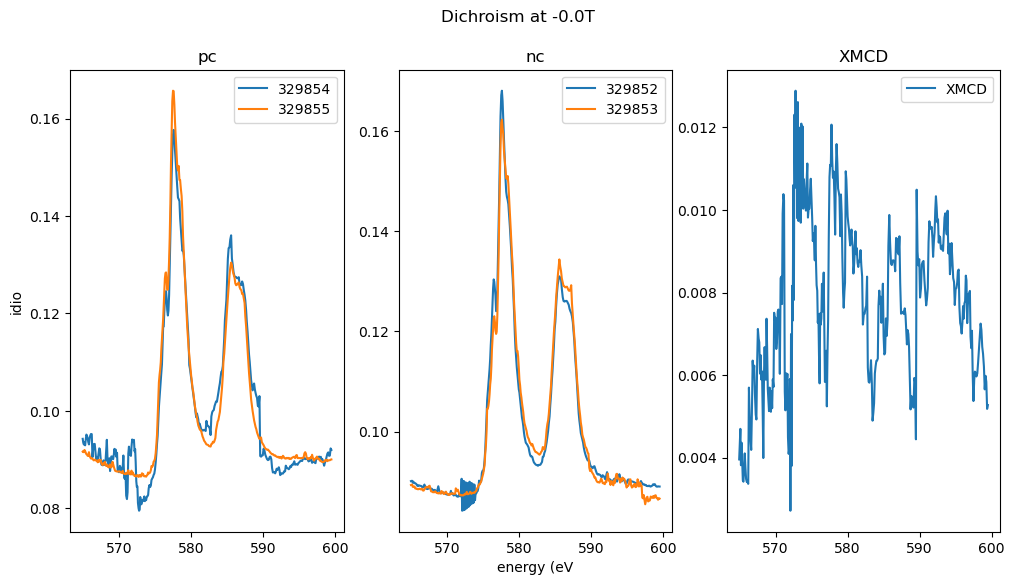

In [94]:

sensor = "TEY"
XMCD_ﬁle_Set = (329852,329853,329854,329855)
XMCD = XMCD_data_analysis()
XMCD.init()
XMCD.load_spectra(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)
